# The TESS full-frame images lightcurve of nova V606 Vul extracted using LightKurve package

This notebook is created to address the referee's comments on the paper "TESS photometry of the nova eruption in V606 Vul: asymmetric photosphere and multiple ejections?" ([arXiv e-print](https://arxiv.org/abs/2311.04903)) submitted to ApJ. While we direct readers to the paper for the final period analysis, this notebook reproduces the main claim: the presence of a ~0.1277 day period in the nova light curve near its peak brightness, using only the standard TESS data analysis package [LightKurve](https://github.com/lightkurve/lightkurve).

The eruption of V606 Vul was happening during the TESS Sector 41 and we start with the analysis of the eruption lightcurve. The same analysis is then applied to the two pre-eruption and three post-eruption TESS sectors covering the nova position to reveal that these sectors contain no useful data as the nova is too faint for TESS outside Sector 41.

We then produce Sector 41 lightcurves for two check stars 4 and 10 arcminutes from the nova to make sure the 0.1277 day modulation found in the nova lightcurve is not present in other sources.

For each source we also extract and analyze the associated off-source (background-only) lightcurve. The Sector 41 background lightcurves are affected by a 0.333 day modulation found consistently for the source and check stars. However, this modulaiton is not detectable in the background-subtracted lightcurves of the nova and check stars.

In [1]:
# Import the packages
import os
import matplotlib.pyplot as plt
import lightkurve as lk  # Importing the lightkurve library for working with TESS data
from photutils.centroids import centroid_com  # Importing function for calculating centroid
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry  # Importing photometry functions
from astropy.stats import sigma_clipped_stats  # Importing sigma-clipped statistics
from lightkurve import LightCurve  # Importing LightCurve class
import numpy as np  # Importing numpy for numerical operations
from astropy.visualization import simple_norm  # Importing visualization tools
from astropy.time import Time  # Importing Time class for handling time conversions
import warnings  # Importing warnings to suppress specific warnings

# Suppress specific warnings from astropy.stats.sigma_clipping
warnings.filterwarnings('ignore', message='Input data contains invalid values', category=UserWarning, module='astropy.stats.sigma_clipping')

# Lightkurve cuts on image quality flags
qualitycuts = 'hard'

from astropy.coordinates import SkyCoord  # Importing SkyCoord class for coordinate conversions
from astropy import units as u  # Importing units from astropy

# Switch to enable or disable writing of all lightcurves
WRITE_ALL_LIGHTCURVES = False

# Switch to enable or disable writing of the best lightcurve in the units of electrons/s
WRITE_BEST_LIGHTCURVE_ELECTRONS = False

# Switch to enable or disable writing of the best lightcurve in the units of magnitude
WRITE_BEST_LIGHTCURVE_MAGNITUDES = False

In [2]:
def simple_detrend_and_period_search(lc, period_range=(0.05, 3.0), titleprefixstring=""):
    """
    Process a LightCurve: clip outliers, detrend, and perform Lomb-Scargle period search.

    Parameters:
    lc (LightCurve): The LightCurve object to process.
    period_range (tuple): The range of periods (in days) to search for periods, default is (0.05, 3.0).
    titleprefixstring (str): A prefix string for titles in the generated plots.

    Returns:
    float: The best period detected by the Lomb-Scargle periodogram.

    Workflow:
    1. Clip Outliers (3-sigma): Removes significant outliers from the lightcurve to clean the data.
    2. Detrend the LightCurve: Uses a 5th-degree polynomial to remove long-term trends.
    3. Re-clip After Detrending: Removes outliers after detrending.
    4. Lomb-Scargle Period Analysis:
       - Converts the specified period range into frequency range.
       - Computes the Lomb-Scargle periodogram.
       - Identifies the best period (highest power).
    5. Generate Plots:
       - Display the sigma-clipped lightcurve.
       - Display the detrended lightcurve.
       - Display the sigma-clipped lightcurve after detrending.
       - Plot the Lomb-Scargle periodogram as a function of frequency, highlighting the best period.
   
    """
    # Step 1: Clip the lightcurve at 3-sigma
    clipped_lc = lc.remove_outliers(sigma=3)
    clipped_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped")
    plt.show()

    # Step 2: Detrend the lightcurve using using scipy's Savitzky-Golay filter wrapped in lc.flatten()
    detrended_lc = clipped_lc.flatten(window_length=101, polyorder=5)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended")
    plt.show()
    
    # Step 2.5: Clip the lightcurve again (to remove mini-flares in nova V606 Vul lightcurve)
    detrended_lc = detrended_lc.remove_outliers(sigma=3)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended, sigma-clipped")
    plt.show()    

    # Step 3: Perform Lomb-Scargle periodogram analysis using LightKurve's built-in functionality
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period

    # Create the periodogram
    periodogram = detrended_lc.to_periodogram(method="lombscargle", 
                                              minimum_frequency=min_frequency, 
                                              maximum_frequency=max_frequency)

    # Find and print the best period
    best_period = periodogram.period_at_max_power
    print(f"The best period is: {best_period:.4f} days")

    # Step 4: Plot the periodogram as a function of frequency
    plt.figure(figsize=(10, 5))
    plt.plot(periodogram.frequency.value, periodogram.power, label="Lomb-Scargle Power")
    plt.axvline(x=1/best_period.value, color="red", linestyle="--", label=f"Best Period = {best_period:.4f} days")
    plt.xlabel("Frequency (1/day)")
    plt.ylabel("Power")
    plt.title(f"{titleprefixstring} Lomb-Scargle Periodogram")
    plt.legend()
    plt.grid()
    plt.show()

    return best_period.value


Target Name: V606 Vul
Target RA/DEC: 20:21:07.7044  +29:14:09.091
SearchResult containing 6 data products.

 #     mission     year  author exptime         target_name          distance
                                   s                                  arcsec 
--- -------------- ---- ------- ------- ---------------------------- --------
  0 TESS Sector 14 2019 TESScut    1426 20:21:07.7044  +29:14:09.091      0.0
  1 TESS Sector 15 2019 TESScut    1426 20:21:07.7044  +29:14:09.091      0.0
  2 TESS Sector 41 2021 TESScut     475 20:21:07.7044  +29:14:09.091      0.0
  3 TESS Sector 55 2022 TESScut     475 20:21:07.7044  +29:14:09.091      0.0
  4 TESS Sector 81 2024 TESScut     158 20:21:07.7044  +29:14:09.091      0.0
  5 TESS Sector 82 2024 TESScut     158 20:21:07.7044  +29:14:09.091      0.0


MAD for input centroid, aperture radius 1.5, annulus 3.5-10.5: 2169.8649339665867 electron / s
MAD for calculated centroid, aperture radius 1.5, annulus 3.5-10.5: 2097.517571650149 electron / s
Best lightcurve: calculated centroid, aperture radius: 1.5 pix, background ring: 3.5-10.5 pix


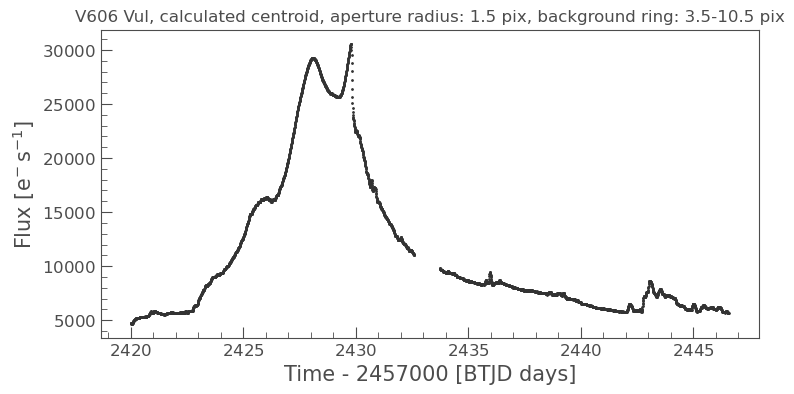

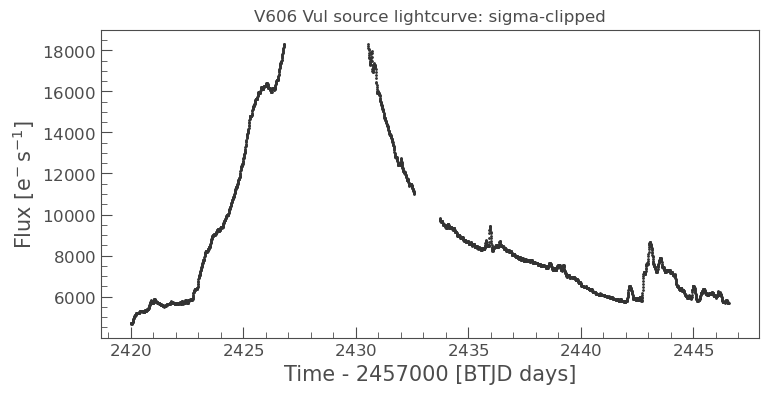

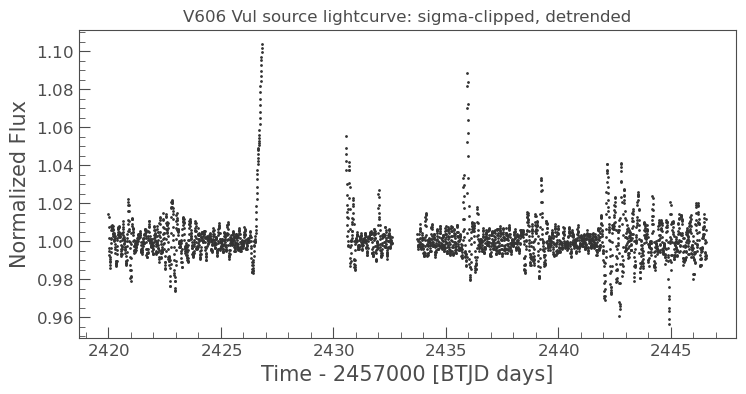

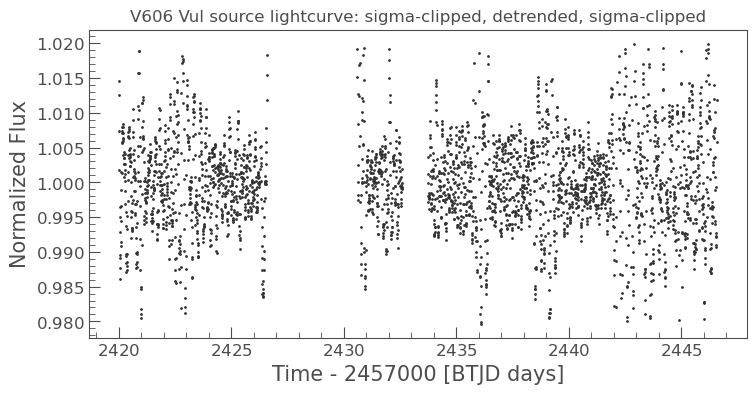

The best period is: 0.1279 d days


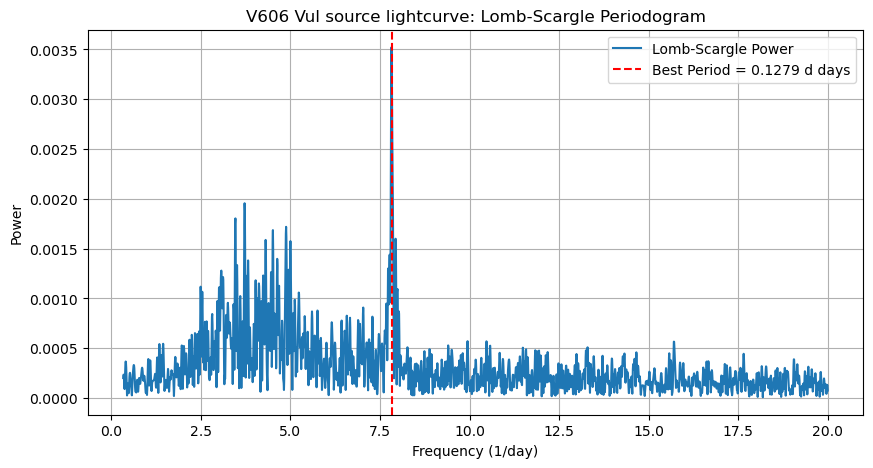

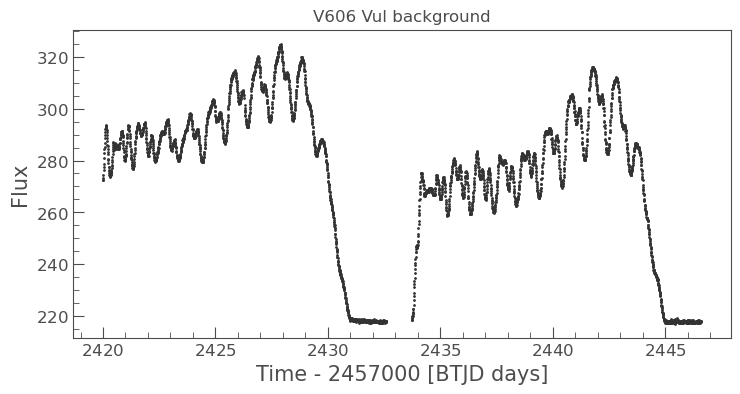

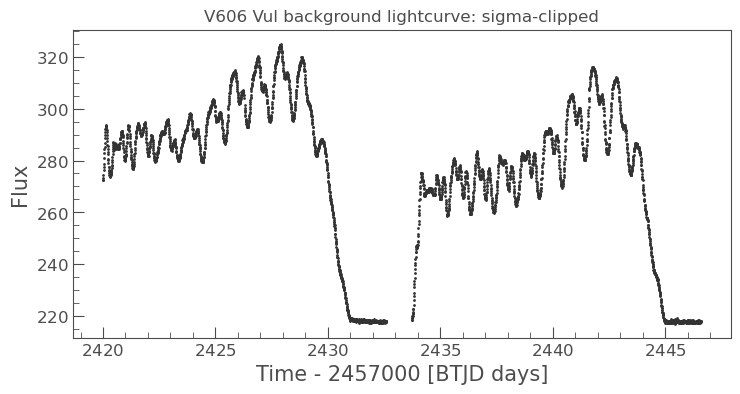

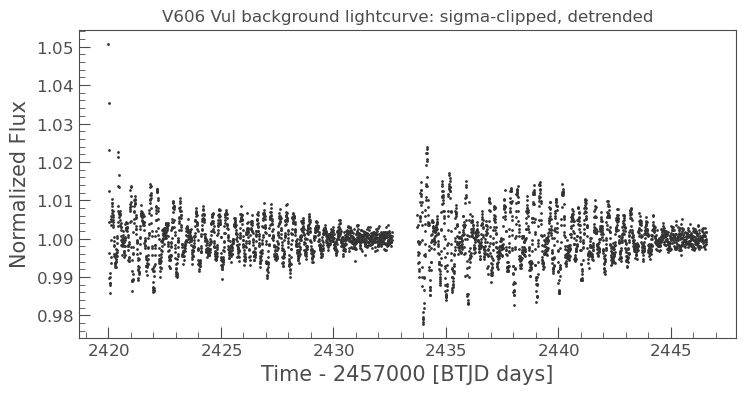

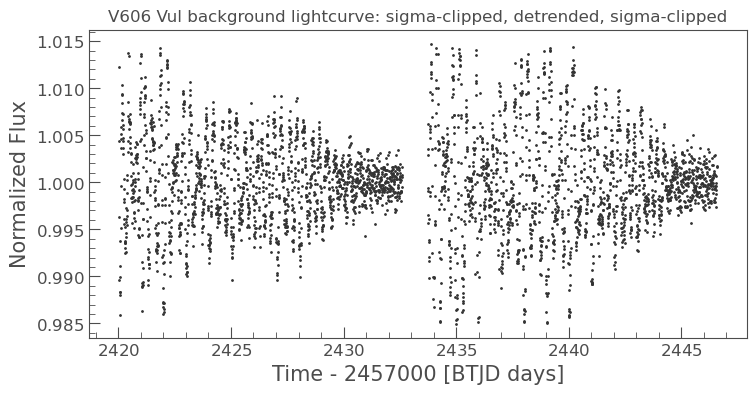

The best period is: 0.3334 d days


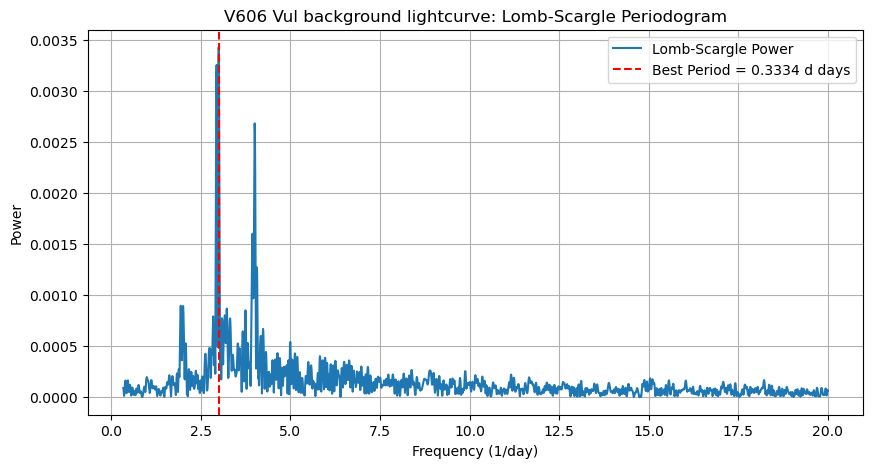

In [3]:
def radec_to_pixel(tpf, target_radec):
    """
    Convert RA/Dec coordinates to pixel coordinates in the TPF.

    Parameters:
    tpf (TargetPixelFile): The target pixel file object.
    target_radec (str): RA/Dec coordinates of the target.

    Returns:
    tuple: Pixel coordinates (x, y).
    """
    coord = SkyCoord.from_name(target_radec)  # Create a SkyCoord object from the RA/Dec string
    pixel = tpf.wcs.world_to_pixel(coord)  # Convert to pixel coordinates using WCS
    return pixel[0].item(), pixel[1].item()  # Return pixel coordinates as a tuple

def calculate_tpf_centroid(tpf, initial_position, aperture_radius=1.5):
    """
    Calculate the centroid of a stacked image from a TPF using the center of mass method.

    Parameters:
    tpf (TargetPixelFile): The target pixel file object.
    initial_position (tuple): Initial guess for the position of the source (x, y).
    aperture_radius (float): Radius of the circular aperture for the initial guess.

    Returns:
    tuple: Centroid position (x_centroid, y_centroid).
    """
    stacked_image = np.nanmedian(tpf.flux, axis=0)  # Stack all cadences to create a median image
    initial_position = np.array(initial_position)  # Ensure initial_position is an array
    aperture = CircularAperture(initial_position, r=aperture_radius)  # Create an aperture mask
    mask = aperture.to_mask(method='center')  # Create a mask from the aperture
    mask_image = mask.to_image(stacked_image.shape)  # Convert mask to image
    sub_image = stacked_image * mask_image  # Extract the sub-image for centroid calculation
    y_centroid_sub, x_centroid_sub = centroid_com(sub_image)  # Calculate the centroid in the sub-image
    return x_centroid_sub, y_centroid_sub  # Return the centroid

def shots_sourcextractor_style_background_estimate_for_1d_data(annulus_data_1d):
    """
    Estimate the background value and standard deviation for 1D annulus data.

    Parameters:
    annulus_data_1d (array): 1D array of annulus data.

    Returns:
    tuple: Background value (median) and standard deviation.
    """
    if len(annulus_data_1d) == 0 or np.all(np.isnan(annulus_data_1d)):
        return np.nan, np.nan  # Return NaN if no valid data
    mean, median, std = sigma_clipped_stats(annulus_data_1d, sigma=3.0, cenfunc='median', stdfunc='mad_std')  # Perform sigma-clipped stats
    return median, std  # Return median and standard deviation

def custom_aperture_photometry_to_lightcurve(tpf, object_position, aperture_radius, annulus_inner_radius, annulus_outer_radius):
    """
    Perform aperture photometry on a target pixel file (TPF) and return a LightCurve object.

    Parameters:
    tpf (TargetPixelFile object): The target pixel file object.
    object_position (tuple): The position of the target (x, y) in pixels.
    aperture_radius (float): Radius of the circular aperture.
    annulus_inner_radius (float): Inner radius of the annular aperture.
    annulus_outer_radius (float): Outer radius of the annular aperture.

    Returns:
    LightCurve object: LightCurve object with the flux values for each cadence.
    """
    
    # Check that the input object position is reasonable
    if not np.all(np.isfinite(object_position)) :
        print("The input pixel position is not a finite number! -- skipping sector " + str(tpf_target.sector) + ' custom_aperture_photometry_to_lightcurve()' )
        return None, None, None

    # Check that the Targe Pixel File (cutout) is not too close to the frame edge
    if tpf_target.column < 44+annulus_outer_radius or tpf_target.column  > 2093-annulus_outer_radius :
        print("Too close to frame edge: tpf_target.column= " + str(tpf_target.column) + ' -- skipping sector ' + str(tpf_target.sector) + ' custom_aperture_photometry_to_lightcurve()')
        return None, None, None
    
    if tpf_target.row < annulus_outer_radius or tpf_target.row > 2049-annulus_outer_radius :
        print("Too close to frame edge: tpf_target.row= " + str(tpf_target.row) + ' -- skipping sector ' + str(tpf_target.sector) + ' custom_aperture_photometry_to_lightcurve()')
        return None, None, None

    flux_values = []
    flux_values_raw = []
    flux_values_bkg_per_pix = []
    flux_values_bkg_std_per_aperture = []
    time_values = tpf.time  # Assuming 'time' attribute is present in tpf

    # Define apertures
    aperture = CircularAperture(object_position, r=aperture_radius)
    annulus_aperture = CircularAnnulus(object_position, r_in=annulus_inner_radius, r_out=annulus_outer_radius)
    sources_mask = tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)  # Create a mask for sources

    for cadence in tpf.flux:
        phot_table = aperture_photometry(cadence, aperture)  # Perform aperture photometry
        cadence[sources_mask] = np.nan  # Assign NaN values to masked pixels for background estimation

        annulus_masks = annulus_aperture.to_mask(method='center')  # Create annulus masks
        annulus_data = annulus_masks.multiply(cadence)  # Multiply masks with cadence
        annulus_data_1d = annulus_data[annulus_masks.data > 0]  # Extract 1D annulus data

        bkg_value, std = shots_sourcextractor_style_background_estimate_for_1d_data(annulus_data_1d)  # Estimate background

        bkg_flux = bkg_value * aperture.area  # Calculate background flux
        bkg_std_per_aperture = std * aperture.area  # Calculate background standard deviation per aperture
        final_flux_raw = phot_table['aperture_sum']  # Extract raw flux
        final_flux = phot_table['aperture_sum'] - bkg_flux  # Subtract background from flux

        if final_flux[0] <= 0.0:
            final_flux[0] = np.nan  # Assign NaN to negative or zero background-subtracted flux values

        if final_flux_raw[0].value <= 50.0:
            final_flux[0] = np.nan  # Assign NaN to suspiciously low raw flux values

        flux_values.append(final_flux[0])  # Append final flux value
        flux_values_raw.append(final_flux_raw[0])  # Append raw flux value
        flux_values_bkg_per_pix.append(bkg_value)  # Append background value per pixel
        flux_values_bkg_std_per_aperture.append(bkg_std_per_aperture)  # Append background standard deviation per aperture

    flux_values_unit = flux_values[0].unit  # Extract units from flux values
    flux_values = np.array([f.value for f in flux_values]) * flux_values_unit  # Convert flux values to array with units
    flux_values_raw = np.array([f.value for f in flux_values_raw]) * flux_values_unit  # Convert raw flux values to array with units
    flux_values_bkg_per_pix = np.array([f.value for f in flux_values_bkg_per_pix])  # Convert background values to array

    bkg_median, bkg_std = shots_sourcextractor_style_background_estimate_for_1d_data(flux_values_bkg_per_pix)  # Estimate background
    bkg_threshold = bkg_median + 3 * bkg_std  # Calculate background threshold

    high_bkg_mask = flux_values_bkg_per_pix > bkg_threshold  # Create mask for high background values
    flux_values[high_bkg_mask] = np.nan  # Assign NaN to high background flux values
    flux_values_raw[high_bkg_mask] = np.nan  # Assign NaN to high background raw flux values

    lc_bkg_subtracted = LightCurve(time=time_values, flux=flux_values, flux_err=flux_values_bkg_std_per_aperture)  # Create LightCurve for background-subtracted flux
    lc_raw = LightCurve(time=time_values, flux=flux_values_raw, flux_err=flux_values_bkg_std_per_aperture)  # Create LightCurve for raw flux
    lc_bkg_per_pix = LightCurve(time=time_values, flux=flux_values_bkg_per_pix)  # Create LightCurve for background per pixel

    return lc_bkg_subtracted, lc_raw, lc_bkg_per_pix  # Return LightCurve objects

def convert_flux_to_mag(time, flux, flux_err):
    """
    Convert flux to magnitudes.

    Parameters:
    time (array): Time values.
    flux (array): Flux values.
    flux_err (array): Flux error values.

    Returns:
    array: Time, magnitude, magnitude error.
    """
    flux = flux.value  # Remove units for log10 calculation
    flux_err = flux_err.value  # Remove units for log10 calculation
    mag = 20.44 - 2.5 * np.log10(flux)  # Convert flux to magnitude
    mag_err = -2.5 * np.log10((flux - flux_err) / flux)  # Calculate magnitude error
    #time_jd = 2457000.0 + time.jd  # Convert TESS JD to regular JD
    time_jd = time.jd
    return time_jd, mag, mag_err  # Return time, magnitude, and magnitude error

# Define target list
target_list = [
    ('V606 Vul', '20:21:07.7044  +29:14:09.091'),
#    ('HD 334199', '20:20:52.1413294 +29:15:52.843623'),
#    ('HD 334200', '20:21:51.5737789 +29:10:49.257564'),
]

stored_lc_targets = []  # List to store target lightcurves
stored_lc_aperture = []  # List to store aperture lightcurves

# Define aperture and annulus radii
#aperture_radii = [1.5, 2.0, 2.5]
aperture_radii = [1.5]
#annulus_radii_pairs = [(3.5, 10.5), (3.5, 7.5), (5.5, 10.5)]
annulus_radii_pairs = [(3.5, 10.5)]

# Create output directory
notebook_name = "v606_vul_lk_circular_aperture"
output_dir = notebook_name.lower().replace(" ", "_")
os.makedirs(output_dir, exist_ok=True)

for target_name, target_radec in target_list:
    print(f"Target Name: {target_name}")
    print(f"Target RA/DEC: {target_radec}")
    search_lc = lk.search_tesscut(target_radec)  # Search TESSCut for the target
    print(search_lc)

    lightcurves_input = {}  # Dictionary to store lightcurves with input centroids
    lightcurves_calculated = {}  # Dictionary to store lightcurves with calculated centroids
    lightcurves_background_per_pix = {} # Dictionary to store background lightcurves

    for search_result in search_lc:
        tpf_target = search_result.download(cutout_size=24, quality_bitmask=qualitycuts)  # Download the target pixel file
        if tpf_target is None:
            continue

        # Initial check that the Targe Pixel File (cutout) is not too close to the frame edge
        if tpf_target.column < 44+10 or tpf_target.column  > 2093-10 :
            print("Too close to frame edge: tpf_target.column= " + str(tpf_target.column) + ' -- skipping sector ' + str(tpf_target.sector) + ' (main script)')
            continue
        if tpf_target.row < 10 or tpf_target.row > 2049-10 :
            print("Too close to frame edge: tpf_target.row= " + str(tpf_target.row) + ' -- skipping sector ' + str(tpf_target.sector) + ' (main script)')
            continue

        initial_x, initial_y = radec_to_pixel(tpf_target, target_radec)  # Convert RA/Dec to pixel coordinates
        # Check that the input object position is reasonable
        if not np.all(np.isfinite( (initial_x, initial_y) )) :
            print("The input pixel position is not a finite number! -- skipping sector " + str(tpf_target.sector) + ' (main script)' )
            continue

        x_centroid_calc, y_centroid_calc = calculate_tpf_centroid(tpf_target, (initial_x, initial_y))  # Calculate centroid
        # Check that the input object position is reasonable
        if not np.all(np.isfinite( (x_centroid_calc, y_centroid_calc) )) :
            print("The calculated pixel position is not a finite number! -- skipping sector " + str(tpf_target.sector) + ' (main script)' )
            continue


        for r in aperture_radii:
            for ann_inner, ann_outer in annulus_radii_pairs:
                # Perform aperture photometry placing the aperture at the source position derived from the input celestial coordinates
                lc_bkg_subtracted_input, lc_raw_input, lc_bkg_per_pix_input = custom_aperture_photometry_to_lightcurve(
                    tpf_target, (initial_x, initial_y), r, ann_inner, ann_outer)
                
                # Check if something went wrong during the lightcurve creation
                # (like target too close to the frame edge)
                if lc_bkg_subtracted_input is None:
                    continue
                
                key = (r, ann_inner, ann_outer, 'input')
                if key not in lightcurves_input:
                    lightcurves_input[key] = lc_bkg_subtracted_input
                else:
                    lightcurves_input[key] = lightcurves_input[key].append(lc_bkg_subtracted_input)

                # Perform aperture photometry for calculated centroid
                lc_bkg_subtracted_calc, lc_raw_calc, lc_bkg_per_pix_calc = custom_aperture_photometry_to_lightcurve(
                    tpf_target, (x_centroid_calc, y_centroid_calc), r, ann_inner, ann_outer)
                
                if lc_bkg_subtracted_calc is None:
                    continue
                
                key = (r, ann_inner, ann_outer, 'calculated')
                if key not in lightcurves_calculated:
                    lightcurves_calculated[key] = lc_bkg_subtracted_calc
                else:
                    lightcurves_calculated[key] = lightcurves_calculated[key].append(lc_bkg_subtracted_calc)
                
                # Assume the background is about the same for 'input' and 'calculated' - just save the latest one
                key = (r, ann_inner, ann_outer, 'background')
                if key not in lightcurves_background_per_pix:
                    lightcurves_background_per_pix[key] = lc_bkg_per_pix_calc
                else:
                    lightcurves_background_per_pix[key] = lightcurves_background_per_pix[key].append(lc_bkg_per_pix_calc)

    def mad(data, axis=None):
        """
        Calculate Median Absolute Deviation (MAD).

        Parameters:
        data (array): Data values.
        axis (int): Axis along which the MAD is calculated.

        Returns:
        float: MAD value.
        """
        median = np.nanmedian(data, axis=axis)  # Calculate median
        mad = np.nanmedian(np.abs(data - median), axis=axis)  # Calculate MAD
        return mad  # Return MAD value

    min_mad_value = float('inf')  # Initialize minimum MAD value
    best_lightcurve = None  # Initialize best lightcurve
    best_description = ""  # Initialize description for the best lightcurve
    best_background_lightcurve = None  # Initialize best background lightcurve

    # Evaluate lightcurves with input centroids
    for key, lc in lightcurves_input.items():
        r, ann_inner, ann_outer, method = key
        lc = lc.remove_nans()  # Remove NaN values
        mad_value = mad(lc.flux)  # Calculate MAD value
        print(f'MAD for {method} centroid, aperture radius {r}, annulus {ann_inner}-{ann_outer}: {mad_value}')
        if mad_value < min_mad_value:
            min_mad_value = mad_value
            best_lightcurve = lc
            best_description = f'{method} Centroid, Aperture Radius: {r}, Annulus Inner Radius: {ann_inner}, Annulus Outer Radius: {ann_outer}'
            # Get corresponding background lightcurve
            background_key = (r, ann_inner, ann_outer, 'background')
            temp_background = lightcurves_background_per_pix[background_key]
            # Make sure to only keep background measurements that correspond to the times in best_lightcurve
            best_background_lightcurve = LightCurve(
                time=lc.time,
                flux=np.pi*r*r*temp_background.flux[np.isin(temp_background.time.value, lc.time.value)]
            )
        title = f"{target_name}_r{r}_ann{ann_inner}-{ann_outer}_{method}"
        output_filename_csv = title.replace(" ", "_") + '_TESS_lk_circap.csv'
        if WRITE_ALL_LIGHTCURVES:
            lc.to_csv(output_filename_csv, overwrite=True)
            print(f'Writing file {output_filename_csv}')

    # Evaluate lightcurves with calculated centroids
    for key, lc in lightcurves_calculated.items():
        r, ann_inner, ann_outer, method = key
        lc = lc.remove_nans()  # Remove NaN values
        mad_value = mad(lc.flux)  # Calculate MAD value
        print(f'MAD for {method} centroid, aperture radius {r}, annulus {ann_inner}-{ann_outer}: {mad_value}')
        if mad_value < min_mad_value:
            min_mad_value = mad_value
            best_lightcurve = lc
            best_description = f'{method} centroid, aperture radius: {r} pix, background ring: {ann_inner}-{ann_outer} pix'
            # Get corresponding background lightcurve
            background_key = (r, ann_inner, ann_outer, 'background')
            temp_background = lightcurves_background_per_pix[background_key]
            # Make sure to only keep background measurements that correspond to the times in best_lightcurve
            best_background_lightcurve = LightCurve(
                time=lc.time,
                flux=temp_background.flux[np.isin(temp_background.time.value, lc.time.value)]
            )
        title = f"{target_name}_r{r}_ann{ann_inner}-{ann_outer}_{method}"
        output_filename_csv = os.path.join(output_dir, title.replace(" ", "_") + '_TESS_lk_circap.csv')
        if WRITE_ALL_LIGHTCURVES:
            lc.to_csv(output_filename_csv, overwrite=True)
            print(f'Writing file {output_filename_csv}')

    # Save the best lightcurve
    if best_lightcurve is not None:
        print(f'Best lightcurve: {best_description}')
        
        # Filter background lightcurve to match best lightcurve timestamps
        # First remove NaNs from best lightcurve to get valid timestamps
        valid_times = ~np.isnan(best_lightcurve.flux)
        best_lightcurve_clean = LightCurve(
            time=best_lightcurve.time[valid_times],
            flux=best_lightcurve.flux[valid_times],
            flux_err=best_lightcurve.flux_err[valid_times] if best_lightcurve.flux_err is not None else None
        )
        
        # Create a matching background lightcurve
        # Use isin to match the timestamps exactly
        matching_times = np.isin(best_background_lightcurve.time.value, best_lightcurve_clean.time.value)
        best_background_lightcurve_clean = LightCurve(
            time=best_background_lightcurve.time[matching_times],
            flux=best_background_lightcurve.flux[matching_times]
        )
        
        if WRITE_BEST_LIGHTCURVE_ELECTRONS:
            best_output_filename_csv = os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_lightcurve.csv")
            best_lightcurve_clean.to_csv(best_output_filename_csv, overwrite=True)
            print(f'Writing best lightcurve to file {best_output_filename_csv}')
            
            # Save corresponding background lightcurve
            best_background_filename_csv = os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_background.csv")
            best_background_lightcurve_clean.to_csv(best_background_filename_csv, overwrite=True)
            print(f'Writing best background lightcurve to file {best_background_filename_csv}')

        if WRITE_BEST_LIGHTCURVE_MAGNITUDES:
            # Convert the best lightcurve to magnitudes and write to a new file
            time_jd, mag, mag_err = convert_flux_to_mag(best_lightcurve_clean.time, 
                                                       best_lightcurve_clean.flux, 
                                                       best_lightcurve_clean.flux_err)
            best_lightcurve_mag = np.column_stack((time_jd, mag, mag_err))
            best_mag_output_filename = os.path.join(output_dir, f"{target_name.replace(' ', '_')}_best_TESS_lightcurve_mag.dat")
            np.savetxt(best_mag_output_filename, best_lightcurve_mag, delimiter=' ', fmt='%.6f %.6f %.6f')
            print(f'Writing best lightcurve (magnitudes) to file {best_mag_output_filename}')
            
        # Display the best lightcurve in its own figure
        best_lightcurve_clean.plot(lw=2, marker='.', linestyle='None')
        plt.title(f"{target_name}, {best_description}")
        # Run the period analysis on the source lightcurve
        simple_detrend_and_period_search(best_lightcurve_clean, period_range=(0.05, 3.0), titleprefixstring=f"{target_name} source lightcurve:")
        
        # Display the corresponding background lightcurve in a separate figure
        best_background_lightcurve_clean.plot(lw=2, marker='.', linestyle='None')
        plt.title(f"{target_name} background")
        # Run the period analysis on the source lightcurve
        simple_detrend_and_period_search(best_background_lightcurve_clean, period_range=(0.05, 3.0), titleprefixstring=f"{target_name} background lightcurve:")


In [4]:
lk.show_citation_instructions()